### Forecasting retail sales. WE will be using data from FREDS -> Federal Economic REserve Data base on retail sales for cothing and clothig accessoties stores.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
retail_data = pd.read_csv("resources/RSCCASN.csv", parse_dates = True, index_col="DATE")

In [7]:
retail_data

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


### Data Exploring

In [8]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [9]:
retail_data.columns = ["sales"]

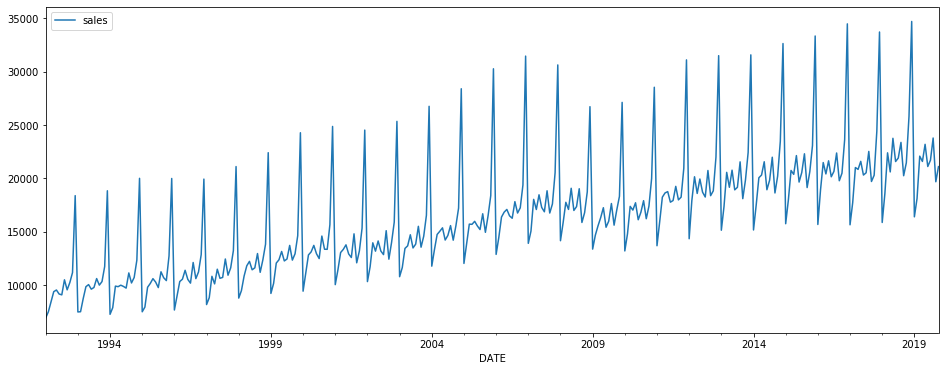

In [12]:
retail_data.plot(figsize = (16,6))

## The to get resonable data for out network we should take at least one year or a bit more of data since er can see there is some kind of sesonality in the data. Looks like our data is going montn to month by the year so 12 rows woul be one year and 18 rows would be 1.5 years. So this is what we will use

In [15]:
test_size = 18
test_index = len(retail_data) - 18

In [16]:
test_index

316

In [18]:
len(retail_data)

334

### lets get out training and testing data

In [24]:
train = retail_data.iloc[:test_index]

In [25]:
test = retail_data.iloc[test_index:]

In [26]:
len(train)

316

In [27]:
len(test)

18

## Training Data

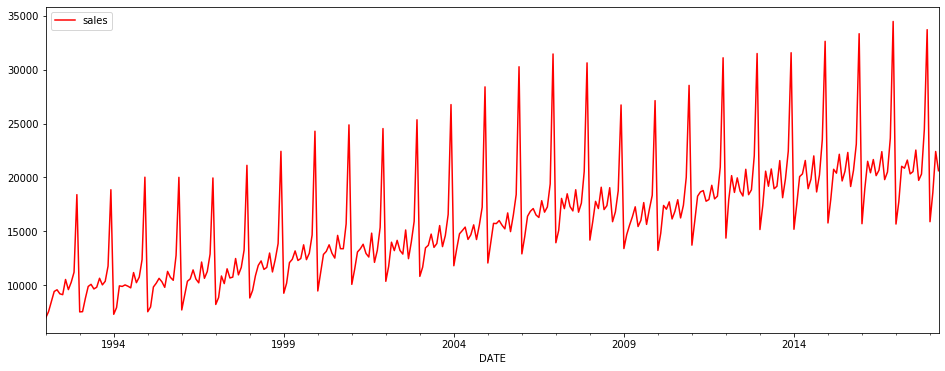

In [31]:
train.plot(figsize = (16,6), c = "r")

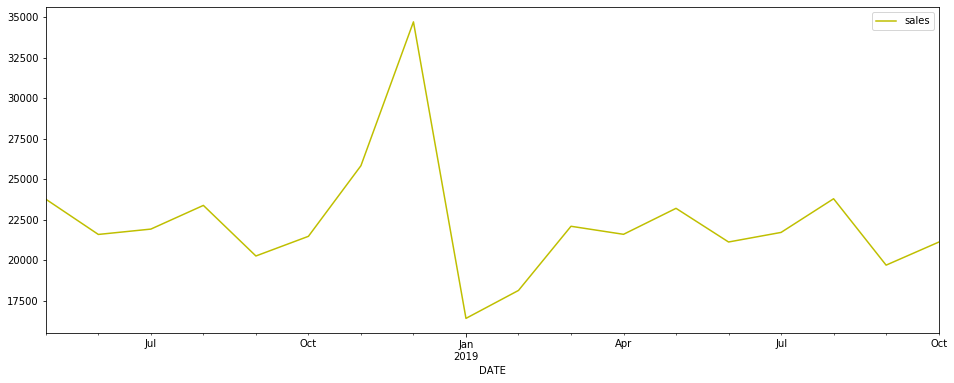

In [34]:
test.plot(figsize =(16,6), c = "y")

## lets scale our data

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scalar = MinMaxScaler()

In [37]:
train_scaled = scalar.fit_transform(train)

In [38]:
test_scaled = scalar.transform(test)

In [40]:
train_scaled.shape

(316, 1)

In [41]:
test_scaled.shape

(18, 1)

### Importing the Time Series Generator  and establish our Batches

In [42]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## Add an early stopping an and a validaiton generator. Will also need to make sure that the length of the batch is less than the length of the test set. Cannot feed a batch odf 1month and expect to get a prediciton of th 19th month on the test set. So a resonable selection would be 12 months

In [43]:
len(test_scaled)

18

In [45]:
length = 12
generator = TimeseriesGenerator(train_scaled,train_scaled, length=length, batch_size=1)

In [46]:
X,y = generator[0]

#### Training on generator feature
- Below X is represented by the 12 values in our batch
- y is th next day(13th day) which is to be predicted
-  Checking this using the scaled Training set and see that the 13th day is == to y so our generator is working great

In [47]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [48]:
y

array([[0.02047633]])

In [51]:
 train_scaled[0:13]

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633]])

###  Creating Model
-we now need to create our model and add early stopping and our validation data using another generaor

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [88]:
n_features = 1 

In [100]:
model = Sequential()
model.add(LSTM(units = 100,activation="relu",input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = 'mse')

In [101]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Early stopping
- because RNN takes time to train we will use early stopping to let tensorflow do the work. This will allow for the training to stop at a low loss value and also allow for a large epoch value

In [102]:
from tensorflow.keras.callbacks import EarlyStopping

In [103]:
early = EarlyStopping(monitor="val_loss", patience= 2)

### Validation Generator 
- we use to validate our training data against the test date 
- Allow us to caputure the validation loss

In [104]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length= length, batch_size=1)

### Fitting the model
- our model is stopping at 3 eopchs


In [105]:
model.fit_generator(generator, validation_data=validation_generator, epochs=20, callbacks=[early])

Epoch 1/20
304/304 [==============================] - 112s 367ms/step - loss: 0.0249 - val_loss: 0.0025
Epoch 2/20
304/304 [==============================] - 111s 367ms/step - loss: 0.0183 - val_loss: 0.0041
Epoch 3/20
304/304 [==============================] - 111s 366ms/step - loss: 0.0116 - val_loss: 0.0011
Epoch 4/20
304/304 [==============================] - 111s 366ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 5/20
304/304 [==============================] - 111s 366ms/step - loss: 0.0036 - val_loss: 4.6278e-04
Epoch 6/20
304/304 [==============================] - 111s 365ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 7/20
304/304 [==============================] - 111s 365ms/step - loss: 0.0015 - val_loss: 1.8237e-04
Epoch 8/20
304/304 [==============================] - 112s 368ms/step - loss: 9.9750e-04 - val_loss: 0.0022
Epoch 9/20
304/304 [==============================] - 111s 366ms/step - loss: 0.0012 - val_loss: 5.1111e-04


## Evaluating our model
- we cna see that our model was very noisy. But lowered the loss at the end

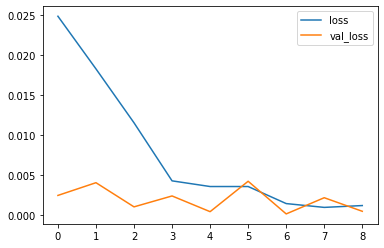

In [106]:
pd.DataFrame(model.history.history).plot()

## Testing model on test data

In [107]:
test_predictions = []
first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1,length, n_features))

for i in range(len(test)):
    current_Prediction = model.predict(current_batch)[0]
    test_predictions.append(current_Prediction)
    current_batch = np.append(current_batch[:,1:,:], [[current_Prediction]], axis = 1)

In [108]:
true_predictions = scalar.inverse_transform(test_predictions)

In [109]:
test["predictions"] = true_predictions

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


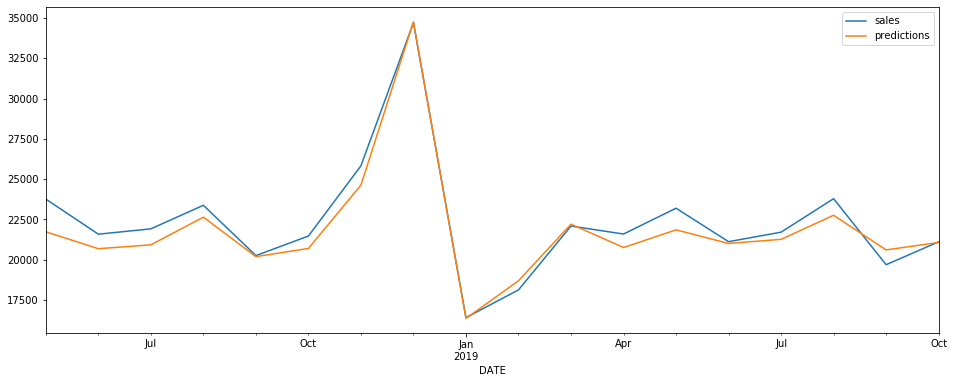

In [110]:
test.plot(figsize = (16,6))

### Forecast
- If we decide this is a good enough predicton to forecast off then we will do so into the future
- Train on all data 
- scaling all data 
- retraining 

In [111]:
full_scalar = MinMaxScaler()

In [112]:
full_scaled_data = full_scalar.fit_transform(retail_data)

In [117]:
length = 12
generator = TimeseriesGenerator(full_scaled_data,full_scaled_data, length=length, batch_size=1)

In [118]:
model = Sequential()
model.add(LSTM(units = 100,activation="relu",input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = 'mse')

## no early Stopping
- WE are using the entire data set so the validation data would be part of the training set for the validation
- epocs would be at the lowest loss in our previous model performance - 8

In [119]:
model.fit_generator(generator=generator, epochs=8)

Epoch 1/8
322/322 [==============================] - 116s 361ms/step - loss: 0.0243
Epoch 2/8
322/322 [==============================] - 116s 361ms/step - loss: 0.0174
Epoch 3/8
322/322 [==============================] - 116s 361ms/step - loss: 0.0106
Epoch 4/8
322/322 [==============================] - 117s 363ms/step - loss: 0.0045
Epoch 5/8
322/322 [==============================] - 116s 361ms/step - loss: 0.0034
Epoch 6/8
322/322 [==============================] - 121s 377ms/step - loss: 0.0025
Epoch 7/8
322/322 [==============================] - 141s 439ms/step - loss: 0.0017
Epoch 8/8
322/322 [==============================] - 142s 442ms/step - loss: 0.0011


## Forecast predictions
--

In [121]:
forecast = []
periods = length
first_batch = full_scaled_data[-length:]
current_batch = first_batch.reshape((1,length,n_features))

for i in range(periods):
    current_predictions = model.predict(current_batch)[0]
    forecast.append(current_predictions)
    current_batch = np.append(current_batch[:,1:,:], [[current_predictions]], axis = 1)

In [122]:
forecast

[array([0.72963256], dtype=float32),
 array([1.1318469], dtype=float32),
 array([0.37261328], dtype=float32),
 array([0.44145003], dtype=float32),
 array([0.567622], dtype=float32),
 array([0.560057], dtype=float32),
 array([0.61977917], dtype=float32),
 array([0.5566015], dtype=float32),
 array([0.5774661], dtype=float32),
 array([0.6467739], dtype=float32),
 array([0.5249066], dtype=float32),
 array([0.5721062], dtype=float32)]

In [123]:
forecast = full_scalar.inverse_transform(forecast)

In [124]:
forecast

array([[27198.43682718],
       [38367.12485123],
       [17284.72558713],
       [19196.18442225],
       [22699.72786093],
       [22489.6623435 ],
       [24148.02798033],
       [22393.71112823],
       [22973.07784986],
       [24897.61695433],
       [21513.60579348],
       [22824.24447775]])

## new date time 

In [125]:
retail_data.tail()

,sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [126]:
date_index = pd.date_range(start = "2019-11-1", periods=periods, freq="MS")

In [127]:
date_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [128]:
for_df = pd.DataFrame(forecast, index=date_index, columns=["forecast"])

In [129]:
for_df

,forecast
2019-11-01,27198.436827
2019-12-01,38367.124851
2020-01-01,17284.725587
2020-02-01,19196.184422
2020-03-01,22699.727861
2020-04-01,22489.662344
2020-05-01,24148.027980
2020-06-01,22393.711128
2020-07-01,22973.077850
2020-08-01,24897.616954


(576, 609)

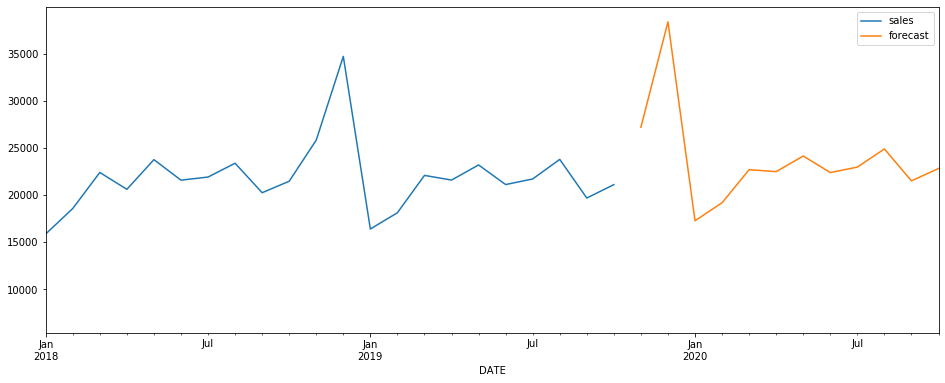

In [137]:
ax = retail_data.plot(figsize = (16,6))
for_df.plot(ax = ax)
plt.xlim("2018-1-1", "2020-10-1")